<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import pandas as pd
import numpy as np
import gensim
import os
import re

from collections import Counter

# Plotting
import squarify
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [88]:
df = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [89]:
df['brand']= df['brand'].replace({'AmazonBasics':'Amazonbasics', 'Amazon':'Amazon', 'Amazonbasics':'Amazonbasics'})

In [107]:
amazon=df.copy()
to_drop = ['reviews.didPurchase', 'reviews.id', 'sourceURLs','reviews.sourceURLs', 'imageURLs', 'asins', 'id', 'asins']
amazon.drop(columns = to_drop, axis = 1, inplace = True)
amazon.shape

(28332, 17)

In [110]:
amazon_sub= amazon[['name','brand','categories','manufacturer', 'reviews.text','reviews.title',]]
#amazon_sub.dropna(subset= ['reviews.doRecommend'], axis = 0,  inplace = True)
amazon_sub.head()

,name,brand,categories,manufacturer,reviews.text,reviews.title
0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...
1,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...
2,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...
3,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...
4,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...


In [111]:
# Choose some columns to combine
col_combined = ['name',
                'brand',
                'categories',
                'manufacturer',       
                'reviews.text',
                'reviews.title',
                ]

# Lowercase and remove symbols from data
for each in col_combined:
    amazon_sub[each] = amazon_sub[each].apply(lambda x: x.lower())
    amazon_sub[each] = amazon_sub[each].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ', x))

# Create the combined text
amazon_sub['combined_text'] = amazon_sub['name'] + ' ' + amazon_sub['brand'] + ' ' + amazon_sub['categories']+ ' ' + amazon_sub['manufacturer'] + ' '+ amazon_sub['reviews.text'] + ' '  + amazon_sub['reviews.title'] 

C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [112]:
amazon_sub.head()

,name,brand,categories,manufacturer,reviews.text,reviews.title,combined_text
0,amazonbasics aaa performance alkaline batterie...,amazonbasics,aa aaa health electronics health household c...,amazonbasics,i order 3 of them and one of the item is bad q...,3 of them and one of the item is bad quali...,amazonbasics aaa performance alkaline batterie...
1,amazonbasics aaa performance alkaline batterie...,amazonbasics,aa aaa health electronics health household c...,amazonbasics,bulk is always the less expensive way to go fo...,always the less expensive way to go for pr...,amazonbasics aaa performance alkaline batterie...
2,amazonbasics aaa performance alkaline batterie...,amazonbasics,aa aaa health electronics health household c...,amazonbasics,well they are not duracell but for the price i...,are not duracell but for the price i am ha...,amazonbasics aaa performance alkaline batterie...
3,amazonbasics aaa performance alkaline batterie...,amazonbasics,aa aaa health electronics health household c...,amazonbasics,seem to work as well as name brand batteries a...,as well as name brand batteries at a much ...,amazonbasics aaa performance alkaline batterie...
4,amazonbasics aaa performance alkaline batterie...,amazonbasics,aa aaa health electronics health household c...,amazonbasics,these batteries are very long lasting the pric...,batteries are very long lasting the price ...,amazonbasics aaa performance alkaline batterie...


In [113]:
STOPWORDS = set(STOPWORDS).union(set(['amazon', 'sell', 'buy']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [114]:
from pandas import Panel
from tqdm import tqdm
tqdm.pandas()

C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  """Entry point for launching an IPython kernel.
C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [115]:
amazon_sub['tokens']= amazon_sub['combined_text'].progress_apply(tokenize)

100%|███████████████████████████████████████████████████████████████████████████████████| 28332/28332 [00:03<00:00, 8619.17it/s]
C:\Users\J8015\anaconda3\envs\U4S12-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
amazon_sub['tokens'].head()

0    [amazonbasics, aaa, performance, alkaline, bat...
1    [amazonbasics, aaa, performance, alkaline, bat...
2    [amazonbasics, aaa, performance, alkaline, bat...
3    [amazonbasics, aaa, performance, alkaline, bat...
4    [amazonbasics, aaa, performance, alkaline, bat...
Name: tokens, dtype: object

In [117]:
def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
# Use the Function
wc = count(amazon_sub['tokens'])

0.8577798389834614

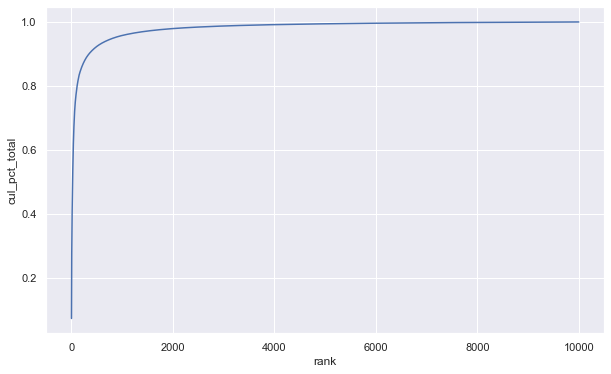

In [119]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,6)})

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

# Percentage of the the top 200 words
wc[wc['rank'] <= 200]['cul_pct_total'].max()

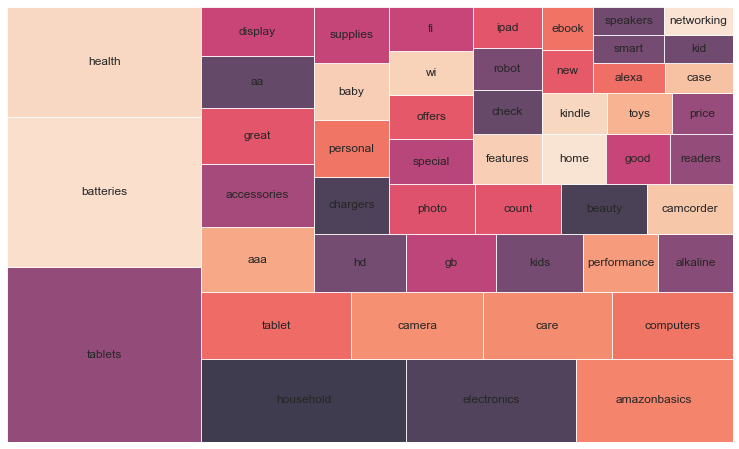

In [120]:
import squarify
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(13,8)})

wc_top20 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

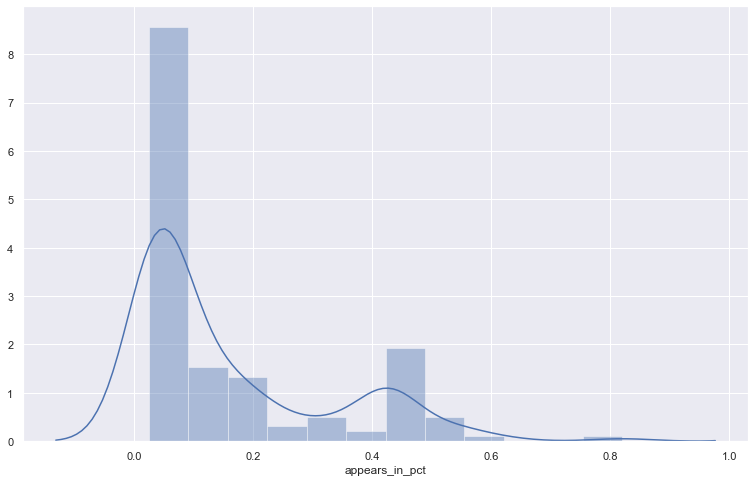

In [121]:
# Tree-Map w/ Words that appear in a least 2.5% of documents. 

wc = wc[wc['appears_in_pct'] >= 0.025]

sns.distplot(wc['appears_in_pct']);

In [123]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(text)
                yield tokens
                
streaming_data = doc_stream(path)

NameError: name 'path' is not defined

In [ ]:
next(streaming_data) # Returns one document at a time from the generator

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling